In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import os
import time
import datetime


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

In [2]:
from DL_Autoencoder import DL_auto as DL

In [3]:




# Define your Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU()
        )
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x





In [4]:
class Autoencoder2deeper(nn.Module):
    def __init__(self):
        super(Autoencoder2deeper, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
        )
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:

class Autoencoder2deeperDO(nn.Module):
    def __init__(self):
        super(Autoencoder2deeperDO, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.enc_conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.5)

        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn3 = nn.BatchNorm2d(16)
        self.dec_conv4 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.enc_conv1(x)))
        x = F.relu(self.bn2(self.enc_conv2(x)))
        x = F.relu(self.bn3(self.enc_conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.enc_conv4(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dropout2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = F.relu(self.dec_bn3(self.dec_conv3(x)))
        x = torch.sigmoid(self.dec_conv4(x))

        return x

In [6]:

class ResNetAutoencoder(nn.Module):
    def __init__(self,target_size=501):
        super(ResNetAutoencoder, self).__init__()

        # Load pre-trained ResNet-50
        resnet = models.resnet50(pretrained=True)

        # Remove the fully connected layers
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.target_size = target_size
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)  # Use Sigmoid for normalizing the output to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.adaptive_avg_pool2d(x, (128, self.target_size))  # adapt to your target size
        return x


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder2deeperDO(nn.Module):
    def __init__(self):
        super(Autoencoder2deeperDO, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.enc_conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.enc_conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.5)

        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn1 = nn.BatchNorm2d(128)
        self.dec_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn2 = nn.BatchNorm2d(64)
        self.dec_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn3 = nn.BatchNorm2d(32)
        self.dec_conv4 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn4 = nn.BatchNorm2d(16)
        self.dec_conv5 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.enc_conv1(x)))
        x = F.relu(self.bn2(self.enc_conv2(x)))
        x = F.relu(self.bn3(self.enc_conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.enc_conv4(x)))
        x = F.relu(self.bn5(self.enc_conv5(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dropout2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = F.relu(self.dec_bn3(self.dec_conv3(x)))
        x = F.relu(self.dec_bn4(self.dec_conv4(x)))
        x = torch.sigmoid(self.dec_conv5(x))

        return x


In [8]:

train_loader, val_loader = DL.create_generators()

Number of files:  39887
True Value:  True
Number of files:  4431
True Value:  True


torch.Size([128, 501])
torch.Size([64, 3, 128, 501])


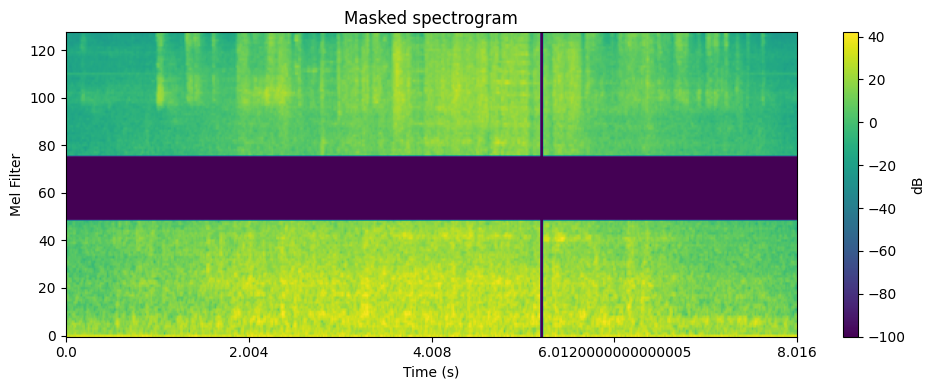

torch.Size([128, 501])
torch.Size([64, 3, 128, 501])


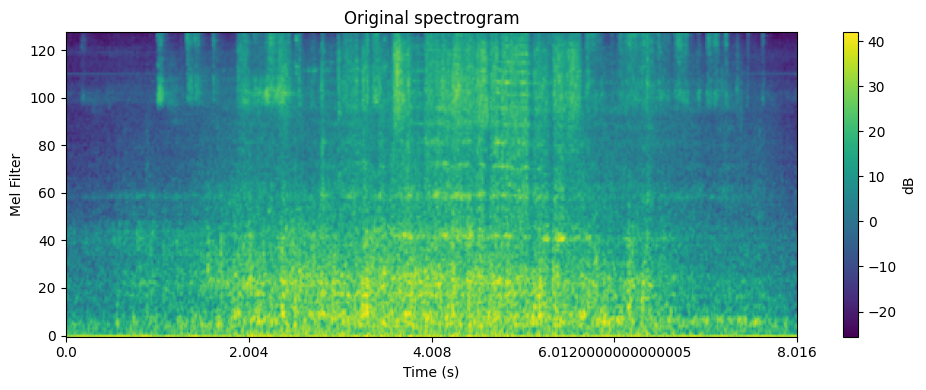

In [9]:
data1, data2 = next(iter(train_loader))

def plot_mel_spectrogram(melspe_db, sample_rate, hop_length, name):
    plt.figure(figsize=(10, 4))

    melspe_db_single = melspe_db[0, 0, :, :].squeeze()

    print(melspe_db_single.shape)
    print(melspe_db.shape)

    if melspe_db_single.ndim != 2:
        raise ValueError("melspe_db_single should be a 2D array")

    # Convert tensor data to numpy for visualization
    melspe_db_np = melspe_db_single.cpu().detach().numpy()

    # Display the spectrogram
    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title(name)

    # Adjust x-axis to show time in seconds
    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), 
               np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

# Call the function with the modified data
plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Masked spectrogram")
plot_mel_spectrogram(data2, sample_rate=32000, hop_length=512,name="Original spectrogram")

In [10]:
data1,_ = next(iter(train_loader))
target_size = data1.shape[3]
print(target_size)
# Instantiate model, loss function, and optimizer
#model = Autoencoder()
#model = Autoencoder2deeper()
#model = Autoencoder2deeperDO()
model = ResNetAutoencoder(target_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

# Move model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

# Training loop
num_epochs = 150



501


c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:

patience = 15  
best_val_loss = float('inf')  
epochs_no_improve = 0  

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for mel_spec_masked, mel_spec in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        mel_spec_masked = mel_spec_masked.to(device)
        mel_spec = mel_spec.to(device)

        optimizer.zero_grad()

        outputs = model(mel_spec_masked)
        _, _, H, W = outputs.size()
        mel_spec = mel_spec[..., :H, :W]

        loss = criterion(outputs, mel_spec)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    average_train_loss = train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mel_spec_masked, mel_spec in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            mel_spec_masked = mel_spec_masked.to(device)
            mel_spec = mel_spec.to(device)

            outputs = model(mel_spec_masked)
            _, _, H, W = outputs.size()
            mel_spec = mel_spec[..., :H, :W]

            loss = criterion(outputs, mel_spec)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    #early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_no_improve = 0
        print(f'Best validation loss: {best_val_loss:.4f}')
    else:
        epochs_no_improve += 1
        print(f'Epochs with no improvement: {epochs_no_improve}')

    if epochs_no_improve == patience:
        print('Early stopping!' )
        break

    


    lr_scheduler.step(val_losses[-1])

    # Print losses
    print(f'Epoch {epoch+1}, Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}')

#save whole model

#model = torch.load('./results/res_auto/resNet_autoen_model.pth')
#model.target_size = target_size

Epoch 1/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 8149.7714
Epoch 1, Average Train Loss: 132.5603, Average Val Loss: 116.4253


Epoch 2/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.05it/s]


Best validation loss: 8166.2912
Epoch 2, Average Train Loss: 124.2306, Average Val Loss: 116.6613


Epoch 3/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 8490.1954
Epoch 3, Average Train Loss: 122.3512, Average Val Loss: 121.2885


Epoch 4/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 8167.0224
Epoch 4, Average Train Loss: 122.0655, Average Val Loss: 116.6717


Epoch 5/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 8053.6617
Epoch 5, Average Train Loss: 121.1182, Average Val Loss: 115.0523


Epoch 6/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.04it/s]


Best validation loss: 8110.7287
Epoch 6, Average Train Loss: 119.9480, Average Val Loss: 115.8676


Epoch 7/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7900.2940
Epoch 7, Average Train Loss: 119.9861, Average Val Loss: 112.8613


Epoch 8/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 8008.3558
Epoch 8, Average Train Loss: 119.3710, Average Val Loss: 114.4051


Epoch 9/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7986.6422
Epoch 9, Average Train Loss: 119.6247, Average Val Loss: 114.0949


Epoch 10/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.04it/s]


Best validation loss: 7826.4242
Epoch 10, Average Train Loss: 119.5260, Average Val Loss: 111.8061


Epoch 11/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 7930.6088
Epoch 11, Average Train Loss: 118.9995, Average Val Loss: 113.2944


Epoch 12/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7907.5762
Epoch 12, Average Train Loss: 118.7703, Average Val Loss: 112.9654


Epoch 13/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7850.9300
Epoch 13, Average Train Loss: 118.7933, Average Val Loss: 112.1561


Epoch 14/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.04it/s]


Best validation loss: 7867.2859
Epoch 14, Average Train Loss: 118.5188, Average Val Loss: 112.3898


Epoch 15/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 7842.1165
Epoch 15, Average Train Loss: 118.6062, Average Val Loss: 112.0302


Epoch 16/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7921.8053
Epoch 16, Average Train Loss: 118.1841, Average Val Loss: 113.1686


Epoch 17/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 7946.7923
Epoch 17, Average Train Loss: 118.0631, Average Val Loss: 113.5256


Epoch 18/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.04it/s]


Best validation loss: 7805.4364
Epoch 18, Average Train Loss: 118.0310, Average Val Loss: 111.5062


Epoch 19/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 7823.7506
Epoch 19, Average Train Loss: 117.8905, Average Val Loss: 111.7679


Epoch 20/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7865.4286
Epoch 20, Average Train Loss: 118.1199, Average Val Loss: 112.3633


Epoch 21/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 7897.3447
Epoch 21, Average Train Loss: 117.7574, Average Val Loss: 112.8192


Epoch 22/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7776.0457
Epoch 22, Average Train Loss: 117.8746, Average Val Loss: 111.0864


Epoch 23/150 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.84it/s]


Best validation loss: 7937.5599
Epoch 23, Average Train Loss: 117.8128, Average Val Loss: 113.3937


Epoch 24/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7806.0971
Epoch 24, Average Train Loss: 117.5587, Average Val Loss: 111.5157


Epoch 25/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7762.6634
Epoch 25, Average Train Loss: 117.4723, Average Val Loss: 110.8952


Epoch 26/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7757.0419
Epoch 26, Average Train Loss: 117.3134, Average Val Loss: 110.8149


Epoch 27/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7741.1627
Epoch 27, Average Train Loss: 117.3789, Average Val Loss: 110.5880


Epoch 28/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7782.5082
Epoch 28, Average Train Loss: 117.2765, Average Val Loss: 111.1787


Epoch 29/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7967.5093
Epoch 29, Average Train Loss: 117.3309, Average Val Loss: 113.8216


Epoch 30/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Best validation loss: 7743.0167
Epoch 30, Average Train Loss: 117.1204, Average Val Loss: 110.6145


Epoch 31/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7818.8915
Epoch 31, Average Train Loss: 117.1866, Average Val Loss: 111.6985


Epoch 32/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7734.2714
Epoch 32, Average Train Loss: 117.2593, Average Val Loss: 110.4896


Epoch 33/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]


Best validation loss: 7823.6291
Epoch 33, Average Train Loss: 116.9014, Average Val Loss: 111.7661


Epoch 34/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 7880.8461
Epoch 34, Average Train Loss: 116.9929, Average Val Loss: 112.5835


Epoch 35/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.00it/s]


Best validation loss: 7795.1215
Epoch 35, Average Train Loss: 116.8689, Average Val Loss: 111.3589


Epoch 36/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Best validation loss: 7818.5256
Epoch 36, Average Train Loss: 116.9972, Average Val Loss: 111.6932


Epoch 37/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7852.4362
Epoch 37, Average Train Loss: 117.5311, Average Val Loss: 112.1777


Epoch 38/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7720.6077
Epoch 38, Average Train Loss: 117.0675, Average Val Loss: 110.2944


Epoch 39/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7749.3804
Epoch 39, Average Train Loss: 116.6387, Average Val Loss: 110.7054


Epoch 40/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.00it/s]


Best validation loss: 7699.0996
Epoch 40, Average Train Loss: 116.5923, Average Val Loss: 109.9871


Epoch 41/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]


Best validation loss: 7711.0972
Epoch 41, Average Train Loss: 116.8728, Average Val Loss: 110.1585


Epoch 42/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7776.1107
Epoch 42, Average Train Loss: 116.6034, Average Val Loss: 111.0873


Epoch 43/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7703.9587
Epoch 43, Average Train Loss: 116.5382, Average Val Loss: 110.0566


Epoch 44/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7759.8927
Epoch 44, Average Train Loss: 116.6438, Average Val Loss: 110.8556


Epoch 45/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]


Best validation loss: 7839.6773
Epoch 45, Average Train Loss: 116.4792, Average Val Loss: 111.9954


Epoch 46/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7955.1102
Epoch 46, Average Train Loss: 116.3466, Average Val Loss: 113.6444


Epoch 47/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7716.0295
Epoch 47, Average Train Loss: 116.4586, Average Val Loss: 110.2290


Epoch 48/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7775.7867
Epoch 48, Average Train Loss: 116.3276, Average Val Loss: 111.0827


Epoch 49/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7820.8037
Epoch 49, Average Train Loss: 116.2584, Average Val Loss: 111.7258


Epoch 50/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7943.6547
Epoch 50, Average Train Loss: 116.9108, Average Val Loss: 113.4808


Epoch 51/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7762.3428
Epoch 00051: reducing learning rate of group 0 to 1.0000e-04.
Epoch 51, Average Train Loss: 116.4209, Average Val Loss: 110.8906


Epoch 52/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7845.3115
Epoch 52, Average Train Loss: 116.0488, Average Val Loss: 112.0759


Epoch 53/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7664.6222
Epoch 53, Average Train Loss: 115.9573, Average Val Loss: 109.4946


Epoch 54/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7728.8583
Epoch 54, Average Train Loss: 116.0113, Average Val Loss: 110.4123


Epoch 55/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.00it/s]


Best validation loss: 7790.0987
Epoch 55, Average Train Loss: 115.9172, Average Val Loss: 111.2871


Epoch 56/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7658.0995
Epoch 56, Average Train Loss: 115.9020, Average Val Loss: 109.4014


Epoch 57/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]


Best validation loss: 7792.0710
Epoch 57, Average Train Loss: 116.3061, Average Val Loss: 111.3153


Epoch 58/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Best validation loss: 7658.8754
Epoch 58, Average Train Loss: 115.8957, Average Val Loss: 109.4125


Epoch 59/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7855.3001
Epoch 59, Average Train Loss: 115.8348, Average Val Loss: 112.2186


Epoch 60/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7831.9129
Epoch 60, Average Train Loss: 115.8753, Average Val Loss: 111.8845


Epoch 61/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]


Best validation loss: 7835.0212
Epoch 61, Average Train Loss: 115.8566, Average Val Loss: 111.9289


Epoch 62/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7777.5059
Epoch 62, Average Train Loss: 115.8529, Average Val Loss: 111.1072


Epoch 63/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Best validation loss: 7848.1623
Epoch 63, Average Train Loss: 115.8403, Average Val Loss: 112.1166


Epoch 64/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7662.4268
Epoch 64, Average Train Loss: 116.0791, Average Val Loss: 109.4632


Epoch 65/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7912.2602
Epoch 65, Average Train Loss: 116.1191, Average Val Loss: 113.0323


Epoch 66/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7710.7883
Epoch 66, Average Train Loss: 115.8774, Average Val Loss: 110.1541


Epoch 67/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.00it/s]


Best validation loss: 7746.7624
Epoch 00067: reducing learning rate of group 0 to 1.0000e-05.
Epoch 67, Average Train Loss: 116.2675, Average Val Loss: 110.6680


Epoch 68/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7758.3177
Epoch 68, Average Train Loss: 115.9392, Average Val Loss: 110.8331


Epoch 69/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7687.8941
Epoch 69, Average Train Loss: 115.7911, Average Val Loss: 109.8271


Epoch 70/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7651.0817
Epoch 70, Average Train Loss: 115.9554, Average Val Loss: 109.3012


Epoch 71/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7653.4197
Epoch 71, Average Train Loss: 115.7712, Average Val Loss: 109.3346


Epoch 72/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7655.8914
Epoch 72, Average Train Loss: 116.3303, Average Val Loss: 109.3699


Epoch 73/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7645.8213
Epoch 73, Average Train Loss: 115.7198, Average Val Loss: 109.2260


Epoch 74/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 7662.7023
Epoch 74, Average Train Loss: 116.0013, Average Val Loss: 109.4672


Epoch 75/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Best validation loss: 7653.0538
Epoch 75, Average Train Loss: 115.7468, Average Val Loss: 109.3293


Epoch 76/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7663.4629
Epoch 76, Average Train Loss: 115.7576, Average Val Loss: 109.4780


Epoch 77/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 7687.3088
Epoch 77, Average Train Loss: 115.7600, Average Val Loss: 109.8187


Epoch 78/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7649.4856
Epoch 78, Average Train Loss: 115.7656, Average Val Loss: 109.2784


Epoch 79/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Best validation loss: 7659.7565
Epoch 79, Average Train Loss: 115.7936, Average Val Loss: 109.4251


Epoch 80/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7790.1659
Epoch 80, Average Train Loss: 116.0555, Average Val Loss: 111.2881


Epoch 81/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7655.3617
Epoch 81, Average Train Loss: 115.8205, Average Val Loss: 109.3623


Epoch 82/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7807.7878
Epoch 82, Average Train Loss: 115.7843, Average Val Loss: 111.5398


Epoch 83/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7636.4121
Epoch 83, Average Train Loss: 115.7744, Average Val Loss: 109.0916


Epoch 84/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7653.5318
Epoch 84, Average Train Loss: 115.7665, Average Val Loss: 109.3362


Epoch 85/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7856.6079
Epoch 85, Average Train Loss: 115.7899, Average Val Loss: 112.2373


Epoch 86/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7655.6916
Epoch 86, Average Train Loss: 115.7741, Average Val Loss: 109.3670


Epoch 87/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7650.6279
Epoch 87, Average Train Loss: 115.7772, Average Val Loss: 109.2947


Epoch 88/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7868.9173
Epoch 88, Average Train Loss: 115.9025, Average Val Loss: 112.4131


Epoch 89/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.00it/s]


Best validation loss: 7653.1882
Epoch 89, Average Train Loss: 115.7440, Average Val Loss: 109.3313


Epoch 90/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7642.7736
Epoch 90, Average Train Loss: 115.7983, Average Val Loss: 109.1825


Epoch 91/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7650.1957
Epoch 91, Average Train Loss: 115.7273, Average Val Loss: 109.2885


Epoch 92/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7645.8922
Epoch 92, Average Train Loss: 116.0018, Average Val Loss: 109.2270


Epoch 93/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Best validation loss: 7802.8626
Epoch 93, Average Train Loss: 115.7788, Average Val Loss: 111.4695


Epoch 94/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7644.1770
Epoch 00094: reducing learning rate of group 0 to 1.0000e-06.
Epoch 94, Average Train Loss: 116.1576, Average Val Loss: 109.2025


Epoch 95/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7642.4062
Epoch 95, Average Train Loss: 116.1097, Average Val Loss: 109.1772


Epoch 96/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7832.0639
Epoch 96, Average Train Loss: 115.7508, Average Val Loss: 111.8866


Epoch 97/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7649.4069
Epoch 97, Average Train Loss: 115.7400, Average Val Loss: 109.2772


Epoch 98/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7733.0080
Epoch 98, Average Train Loss: 116.1137, Average Val Loss: 110.4715


Epoch 99/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7824.3492
Epoch 99, Average Train Loss: 115.9755, Average Val Loss: 111.7764


Epoch 100/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7653.5986
Epoch 100, Average Train Loss: 116.1255, Average Val Loss: 109.3371


Epoch 101/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7652.5993
Epoch 101, Average Train Loss: 115.7448, Average Val Loss: 109.3228


Epoch 102/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.00it/s]


Best validation loss: 7649.5288
Epoch 102, Average Train Loss: 115.8601, Average Val Loss: 109.2790


Epoch 103/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7650.4843
Epoch 103, Average Train Loss: 115.7774, Average Val Loss: 109.2926


Epoch 104/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7652.5441
Epoch 104, Average Train Loss: 115.7253, Average Val Loss: 109.3221


Epoch 105/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.00it/s]


Best validation loss: 7660.7874
Epoch 00105: reducing learning rate of group 0 to 1.0000e-07.
Epoch 105, Average Train Loss: 115.7608, Average Val Loss: 109.4398


Epoch 106/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7644.5838
Epoch 106, Average Train Loss: 115.7445, Average Val Loss: 109.2083


Epoch 107/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7645.6669
Epoch 107, Average Train Loss: 115.8241, Average Val Loss: 109.2238


Epoch 108/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Best validation loss: 7650.6153
Epoch 108, Average Train Loss: 115.7499, Average Val Loss: 109.2945


Epoch 109/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7652.9229
Epoch 109, Average Train Loss: 116.0666, Average Val Loss: 109.3275


Epoch 110/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7716.9754
Epoch 110, Average Train Loss: 115.7463, Average Val Loss: 110.2425


Epoch 111/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7655.3592
Epoch 111, Average Train Loss: 115.7392, Average Val Loss: 109.3623


Epoch 112/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7648.4198
Epoch 112, Average Train Loss: 115.7709, Average Val Loss: 109.2631


Epoch 113/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7871.0399
Epoch 113, Average Train Loss: 116.0425, Average Val Loss: 112.4434


Epoch 114/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Best validation loss: 7879.0704
Epoch 114, Average Train Loss: 116.0797, Average Val Loss: 112.5581


Epoch 115/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7651.9215
Epoch 115, Average Train Loss: 115.7411, Average Val Loss: 109.3132


Epoch 116/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7657.3236
Epoch 00116: reducing learning rate of group 0 to 1.0000e-08.
Epoch 116, Average Train Loss: 115.7623, Average Val Loss: 109.3903


Epoch 117/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Best validation loss: 7649.4235
Epoch 117, Average Train Loss: 115.7609, Average Val Loss: 109.2775


Epoch 118/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Best validation loss: 7664.4021
Epoch 118, Average Train Loss: 115.7597, Average Val Loss: 109.4915


Epoch 119/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7791.7302
Epoch 119, Average Train Loss: 116.3998, Average Val Loss: 111.3104


Epoch 120/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Best validation loss: 7652.4481
Epoch 120, Average Train Loss: 115.7631, Average Val Loss: 109.3207


Epoch 121/150 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.02it/s]


Best validation loss: 7658.0726
Epoch 121, Average Train Loss: 115.8248, Average Val Loss: 109.4010


Epoch 122/150 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.98it/s]


Best validation loss: 7662.3062
Epoch 122, Average Train Loss: 115.8516, Average Val Loss: 109.4615


Epoch 123/150 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.93it/s]


Best validation loss: 7656.7818
Epoch 123, Average Train Loss: 115.7844, Average Val Loss: 109.3826


Epoch 124/150 - Training:  21%|██        | 128/624 [01:21<05:14,  1.58it/s]


KeyboardInterrupt: 

In [12]:
torch.save(model, './results/res_auto/resNetTry23_11_autoen_model.pth')


Number of files:  39887
True Value:  True
Number of files:  4431
True Value:  True
torch.Size([128, 501])
torch.Size([1, 3, 128, 501])


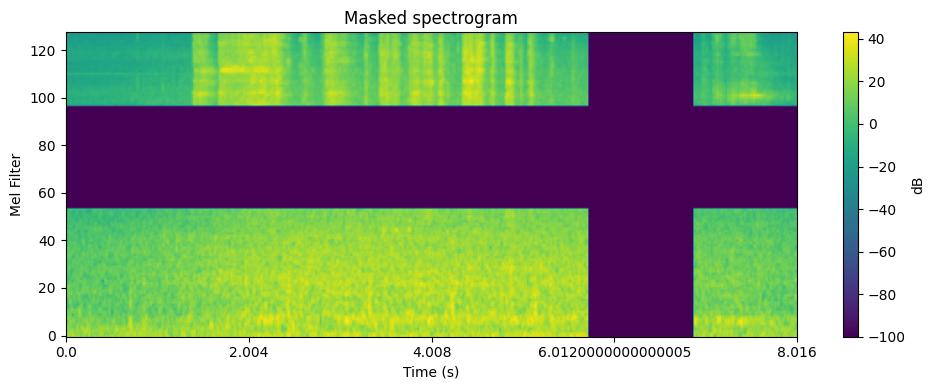

torch.Size([128, 501])
torch.Size([1, 3, 128, 501])


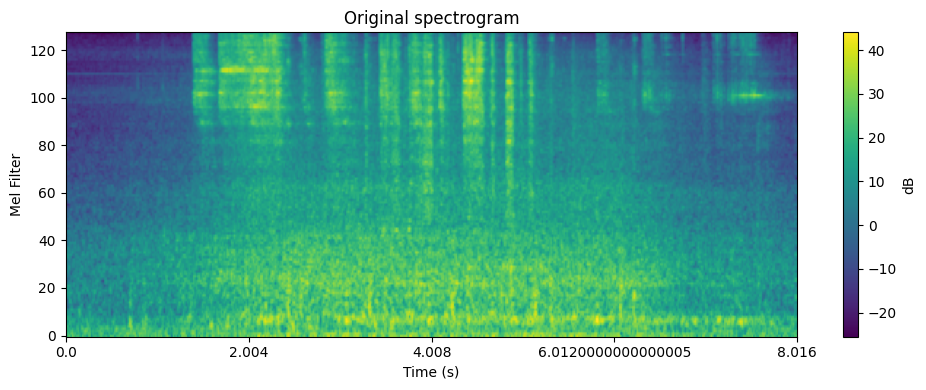

torch.Size([128, 501])
torch.Size([1, 3, 128, 501])


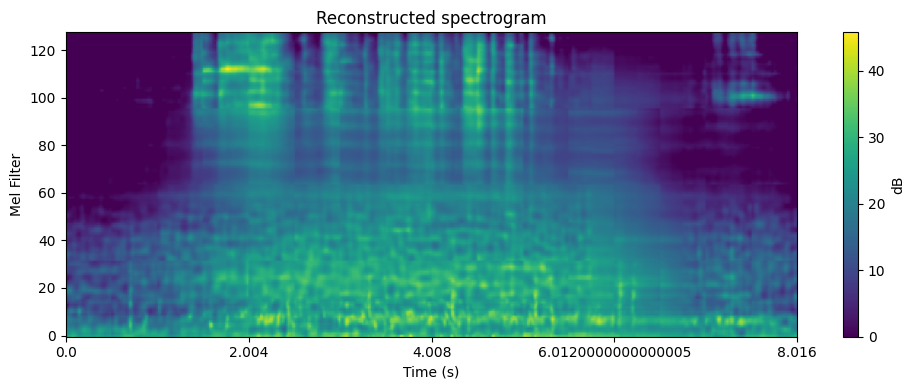

In [15]:

config.batch_size = 1
train_loader, val_loader = DL.create_generators()


#d3elete cuda cache
torch.cuda.empty_cache()
data1, data2 = next(iter(val_loader))
outputs = model(data1)


plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Masked spectrogram")
plot_mel_spectrogram(data2, sample_rate=32000, hop_length=512,name="Original spectrogram")
plot_mel_spectrogram(outputs, sample_rate=32000, hop_length=512,name="Reconstructed spectrogram")
config.batch_size = 64

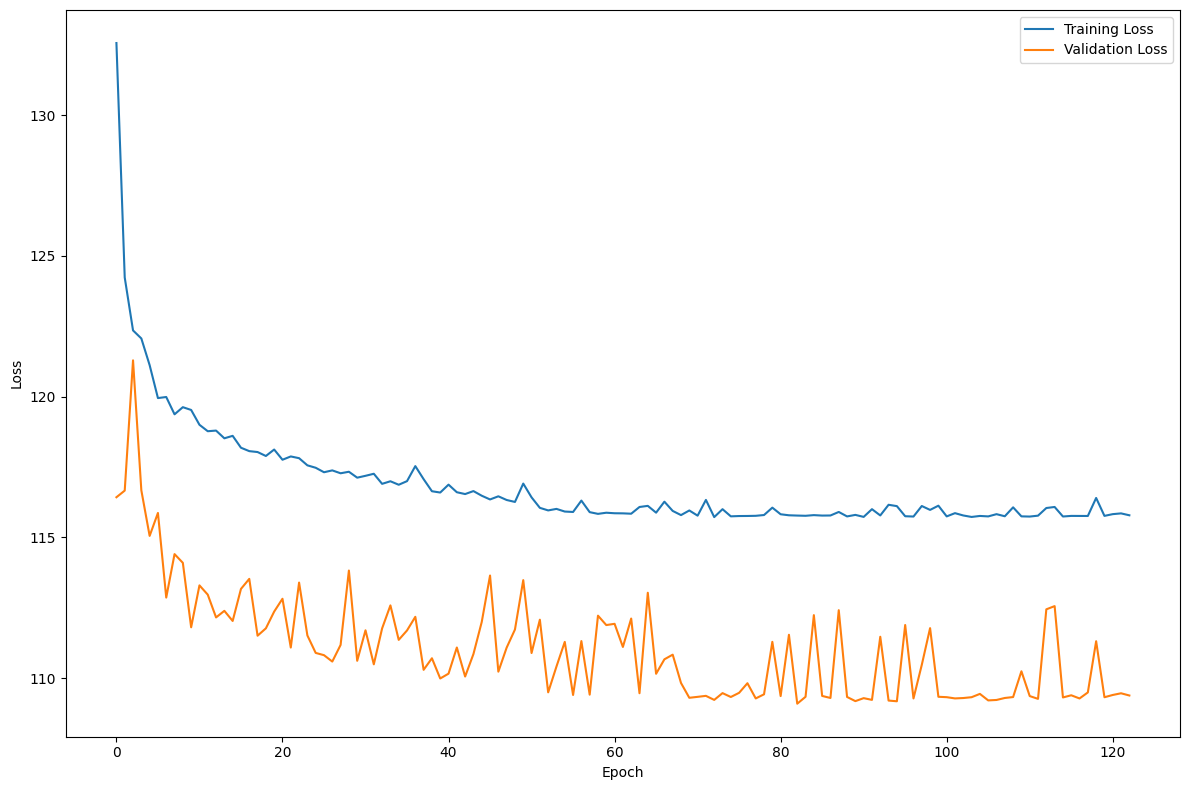

In [16]:
#plot loss
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
